# Bedrock AgentCore Memory Checkpointer - Human in the Loop Example

This sample notebook walks through setup and usage of the Bedrock AgentCore Memory Checkpointer with LangGraph. This example specifically showcases the ability to use a human-in-the-loop workflow to interrupt graph execution and resume it with human intervention.

This notebook closely follows the walkthrough here on LangGraph - https://langchain-ai.github.io/langgraph/tutorials/get-started/4-human-in-the-loop/

### Setup
For this notebook you will need:
1. An Amazon Web Services development account
2. Bedrock Model Access (i.e. Claude 3.7 Sonnet)
3. An AgentCore Memory Resource configured (see below section for details)

### AgentCore Memory Resource

Either in the AWS developer portal or using the boto3 library you must create an [AgentCore Memory Resource](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agentcore-control/client/create_memory.html). For just using the `AgentCoreMemorySaver` checkpointer in this notebook, you do not need to specify any specific long-term memory strategies. However, it may be beneficial to supplement this approach with the `AgentCoreMemoryStore` to save and extract conversational insights, so you may want to enable strategies for that use case.

Once you have the Memory enabled and in a `ACTIVE` state, take note of the `memoryId`, we will need it later.

In [1]:
# Import LangGraph and LangChain components
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent

# Imports that enable human-in-the-loop
from langgraph.types import Command, interrupt

In [2]:
# Import the AgentCoreMemorySaver that we will use as a checkpointer
from langgraph_checkpoint_aws import AgentCoreMemorySaver

import logging
logging.getLogger().setLevel(logging.DEBUG)

## AgentCore Memory Configuration
- `REGION` corresponds to the AWS region that your resources are present in, these are passed to the `AgentCoreMemorySaver`.
- `MEMORY_ID` corresponds to your top level AgentCore Memory resource. Within this resource we will store checkpoints for multiple actors and sessions
- `MODEL_ID` this is the bedrock model that will power our LangGraph agent through Bedrock Converse.

We will use the `MEMORY_ID` and any additional boto3 client keyword args (in our case, `REGION`) to instantiate our checkpointer.

In [11]:
REGION = "us-west-2"
MEMORY_ID = "YOUR_MEMORY_ID"
MODEL_ID = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"

# Initialize checkpointer for state persistence
checkpointer = AgentCoreMemorySaver(MEMORY_ID, region_name=REGION)

# Initialize LLM
llm = init_chat_model(MODEL_ID, model_provider="bedrock_converse", region_name=REGION)

## Enable the Human Assistance Tool

Using the LangGraph `interrupt` type, we can interrupt the agent graph execution to give the chance for a human to intervene and respond to the query to continue execution. 

In [4]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

@tool
def add(a: int, b: int):
    """Add two integers and return the result"""
    return a + b

@tool
def multiply(a: int, b: int):
    """Multiply two integers and return the result"""
    return a * b


tools = [add, multiply, human_assistance]

# Bind the tools to our LLM so it can understand their structure
llm_with_tools = llm.bind_tools(tools)

## Build our LangGraph agent graph

Our agent will be built with the `create_react_agent` builder. It just has a few simple nodes, mainly a chatbot node and a tool node. This will enable our chatbot to use the add, multiply, and human assistance tools as much as it needs and then return a response. We will visualize this graph below.

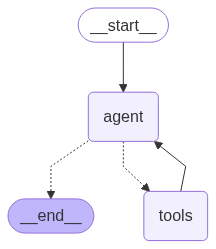

In [5]:
graph = create_react_agent(
    model=llm_with_tools,
    tools=tools,
    prompt="You are a helpful assistant",
    checkpointer=checkpointer,
)

graph

## IMPORTANT: Input and Config

For this example we will ask explicitly for user assistance to make sure that the human assistance tool is called. In reality, this could be triggered by several conditions, for example a safety flag may route a conversation to a human if certain keywords are used.

### Graph Invoke Input
We only need to pass the newest user message in as an argument `inputs`. This could include other state variables too but for the simple `create_react_agent`, messages are all that's required.

### LangGraph RuntimeConfig
In LangGraph, config is a `RuntimeConfig` that contains attributes that are necessary at invocation time, for example user IDs or session IDs. For the `AgentCoreMemorySaver`, `thread_id` and `actor_id` must be set in the config. For instance, your AgentCore invocation endpoint could assign this based on the identity or user ID of the caller. Additional documentation here: [https://langchain-ai.github.io/langgraphjs/how-tos/configuration/](https://langchain-ai.github.io/langgraphjs/how-tos/configuration/)



For the example, when the human assistance tool is called we expect the execution to be interrupted until a human intervenes.

In [8]:
user_input = "I'm frustrated with my current support. Please loop in a human."
config = {"configurable": {"thread_id": "2", "actor_id": "demo-notebook"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm frustrated with my current support. Please loop in a human.
================================== Ai Message ==================================

[{'type': 'text', 'text': "I understand you're feeling frustrated and would like to speak with a human for support. I can certainly help you request human assistance."}, {'type': 'tool_use', 'name': 'human_assistance', 'input': {'query': 'User is frustrated with current support and has requested to speak with a human representative.'}, 'id': 'tooluse_6FDef0XWQhGv0aiA3D3_IQ'}]
Tool Calls:
  human_assistance (tooluse_6FDef0XWQhGv0aiA3D3_IQ)
 Call ID: tooluse_6FDef0XWQhGv0aiA3D3_IQ
  Args:
    query: User is frustrated with current support and has requested to speak with a human representative.


### Human-in-the-loop

As you can see, execution paused when the human assistance tool was called. Inspecting the state (which uses the AgentCore memory checkpointer), you can see that the execution stopped at the tool node.

In [9]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

### Responding as a Human

Using the LangGraph `Command` with our response, we can resume the execution and pass our response back to the LLM for it to respond to the user. This powerful workflow is enabled by checkpointing so that conversation and graph state is persisted under the hood, enabling pausing and resuming chats on demand through certain conditions. 

In [10]:
human_response = (
    "I'm sorry to hear that you are frustrated. Looking at the past conversation history, I can see that you've requested a refund. I've gone ahead and credited it to your account."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': "I understand you're feeling frustrated and would like to speak with a human for support. I can certainly help you request human assistance."}, {'type': 'tool_use', 'name': 'human_assistance', 'input': {'query': 'User is frustrated with current support and has requested to speak with a human representative.'}, 'id': 'tooluse_6FDef0XWQhGv0aiA3D3_IQ'}]
Tool Calls:
  human_assistance (tooluse_6FDef0XWQhGv0aiA3D3_IQ)
 Call ID: tooluse_6FDef0XWQhGv0aiA3D3_IQ
  Args:
    query: User is frustrated with current support and has requested to speak with a human representative.
================================= Tool Message =================================
Name: human_assistance

I'm sorry to hear that you are frustrated. Looking at the past conversation history, I can see that you've requested a refund. I've gone ahead and credited it to your account.
================================== Ai 